In [1]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [2]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [3]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-05,110.333336,112.000000,110.000000,110.800003,88.074112,8203155
2018-04-06,110.533333,112.000000,110.050003,111.416664,88.564308,5043570
2018-04-09,111.366669,111.849998,109.833336,110.266663,87.650177,6096675
2018-04-10,111.400002,111.483330,110.099998,110.650002,87.954895,5929812
2018-04-11,110.716667,111.666664,107.433334,109.000000,86.643311,10268877


In [6]:
len(data)

1237

In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-28,103.900002,104.500000,103.250000,104.150002,104.150002,7814715
2023-03-29,104.150002,106.199997,104.000000,105.500000,105.500000,10745581
2023-03-31,105.750000,107.000000,104.849998,105.150002,105.150002,15641500
2023-04-03,105.449997,106.949997,104.900002,105.449997,105.449997,11147157
2023-04-05,105.750000,106.199997,104.300003,105.400002,105.400002,5312283


In [8]:
opn = data[['Open']]

<Axes: xlabel='Date'>

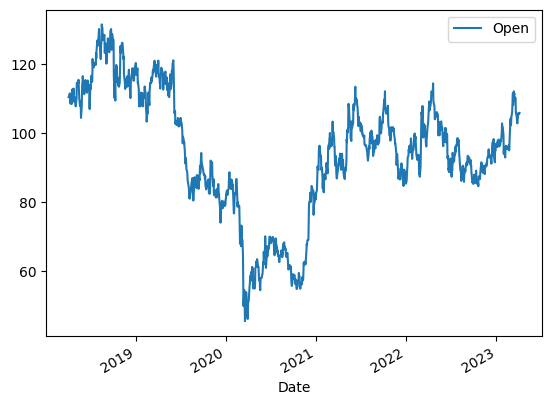

In [9]:
opn.plot()

In [10]:
import matplotlib.pyplot as plt

In [11]:
ds = opn.values

In [12]:
ds

array([[110.33333588],
       [110.53333282],
       [111.3666687 ],
       ...,
       [105.75      ],
       [105.44999695],
       [105.75      ]])

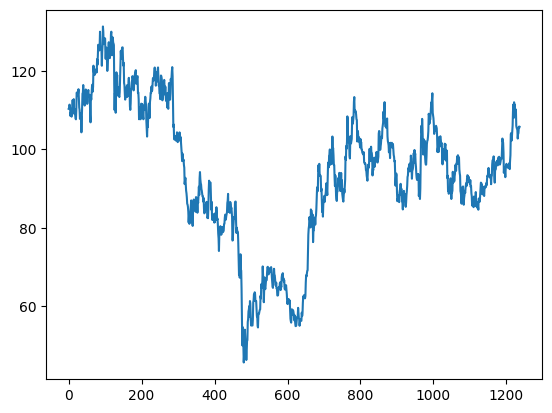

In [13]:
plt.plot(ds)

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [17]:
len(ds_scaled), len(ds)

(1237, 1237)

In [18]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [19]:
train_size,test_size

(865, 372)

In [20]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [21]:
len(ds_train),len(ds_test)

(865, 372)

In [22]:
#creating dataset in time series for LSTM model 
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [23]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [24]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [25]:
X_test.shape, y_test.shape

((271, 100), (271,))

In [26]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [28]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 14s 679ms/step - loss: 0.1329 - val_loss: 0.0064
Epoch 2/100
12/12 [==============================] - 5s 426ms/step - loss: 0.0164 - val_loss: 0.0031
Epoch 3/100
12/12 [==============================] - 6s 500ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 4/100
12/12 [==============================] - 4s 318ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 5/100
12/12 [==============================] - 2s 195ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 6/100
12/12 [==============================] - 2s 190ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 7/100
12/12 [==============================] - 3s 223ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 8/100
12/12 [==============================] - 3s 245ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 9/100
12/12 [==============================] - 2s 192ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/100
12/12 [==============================] - 2s 196ms/step - loss: 0.0039 - val_l

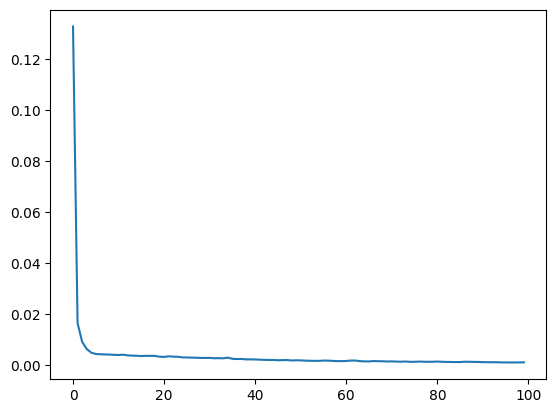

In [30]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [31]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 38ms/step


In [32]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

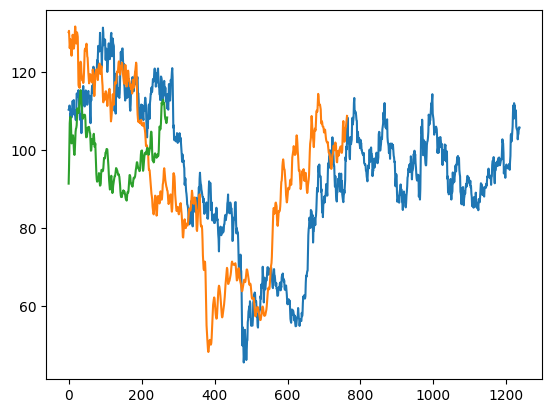

In [33]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [34]:
type(train_predict)

numpy.ndarray

In [35]:
test = np.vstack((train_predict,test_predict))

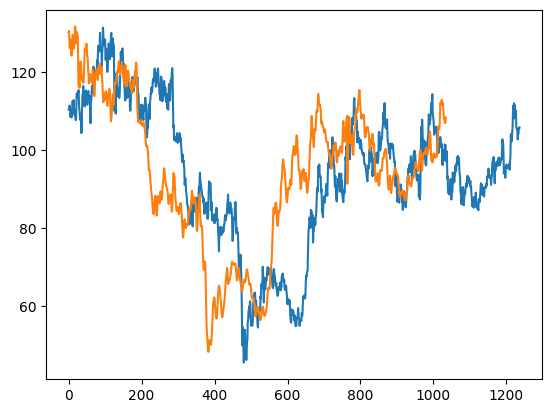

In [36]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [37]:
len(ds_test)

372

In [38]:
#Getting the last 100 days records
fut_inp = ds_test[270:370]

In [39]:
fut_inp = fut_inp.reshape(1,-1)

In [40]:
tmp_inp = list(fut_inp)

In [41]:
fut_inp.shape

(1, 100)

In [42]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [43]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7316917777061462], [0.7545742988586426], [0.7790356278419495], [0.8010692000389099], [0.8198280930519104], [0.835541307926178], [0.8487122654914856], [0.8599218130111694], [0.8697541356086731], [0.878730058670044], [0.8872635960578918], [0.8956441879272461], [0.9040467143058777], [0.9125563502311707], [0.9211940169334412], [0.929940402507782], [0.9387539625167847], [0.9475820660591125], [0.9563723206520081], [0.9650741815567017], [0.9736457467079163], [0.9820520281791687], [0.9902661442756653], [0.9982706904411316], [1.0060540437698364], [1.0136103630065918], [1.0209391117095947], [1.0280417203903198], [1.0349221229553223], [1.0415867567062378]]


In [44]:
len(ds_scaled)

1237

In [45]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

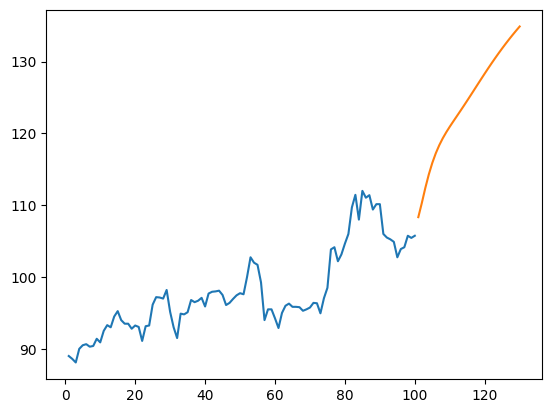

In [47]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1137:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [48]:
ds_new = ds_scaled.tolist()

In [51]:
len(ds_new)

1267

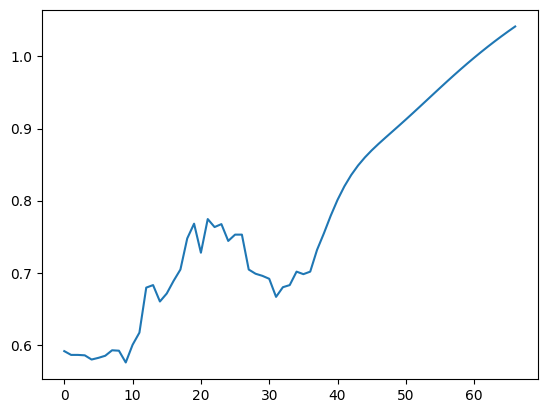

In [49]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [50]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

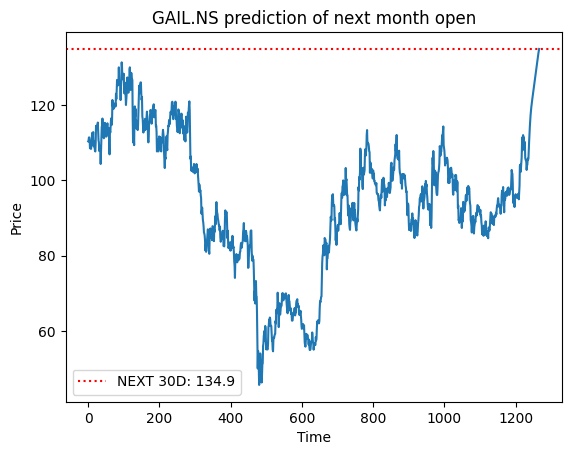

In [52]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()